# Spike Train Analysis Tools

This notebook includes a demonstration for spike train analysis tools in Python.

This tool works by accepting data generated from matlab processing that makes it parsable in Python. The logic for parsing is found in calculate_afferet_isi_stats() in spiketrainanalysis.py, and the functiona trial_isi_probability_distribution() trial_distance_probability_distribution() accept most matlab-output files to produce visualizations for analytics on spiking neurons.

This tool seeks to accomplish producing comparisons between the following: 

    1) Different neurons or different neuron types in a given file  
    2) Responses to different objects or dimension for a given neuron  
    3) Responses to the same object/dimension but different trials for a given neuron  
    4) Same neuron and experimental conditions but different SNRs  
    5) Different locations for a given neuron type in a given file  

The file trialstats.py abstracts functionality from trial_isi_probability_distribution() into 6 functions that perform the above analyses:

    1) compare_neuron()   # Compares 2 different neurons across trials 
    2) compare_afferent() # Compares 2 different afferent types (sa, ra, pc) across trials  
    3) compare_response() # Compares 2 different experimental responses (e.g. object 1 vs object 3)  
    4) compare_trial()    # Compares 2 different trials of the same experiement (e.g. trial 2 vs trial 4)  
    5) compare_noise()    # Compares 2 different noise profiles (e.g. 0 dB noise vs 9 dB noise) 
    6) compare_location() # Compares 2 different stimulus points based on x-y coordinates

Each function returns the KL divergence (pq + qp)

Notes \
-Occasionally when selecting a specific neuron, a TrueDivide warning may be thrown. This will happen when a neuron did not fire during the experiment. This results in little/no spike intervals, which will fail the ISI calculation.
-Also when selecting a neuron, that neuron's distance from the origin may be greater than the higher end of the bin range. This causes an error because all bins in the plot are 0%, since the [only] data point is beyond the range of the bins. When this is detected, the n_bins variable will switch to the default value of 10 uniformly-sized bins.

In [1]:
#  Import the toolset
import sys; sys.path.insert(0, '..') # This line allows imports from the parent directory /blast/
import spiketrainanalysis as sta
import trialstats as ts
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

#  Suppress print statements (restart Notebook and kernel to undo):
# import sys, os
# sys.stdout = open(os.devnull, 'w')

# Widen Jupyter cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#  Set the directory where .mat files are found. Nesting of directories is allowed (e.g. for noise profile sweep)
data_dir='../data/'

#  The user can specify filenames if (s)he desires a specific combination of files 
files = ['spikes_ftsn_object_1_dim_2_trial_1.mat',
         'spikes_ftsn_object_1_dim_2_trial_2.mat',
         'spikes_ftsn_object_1_dim_2_trial_3.mat']

#  Note: filenames may have several instances (e.g. nested within different noise profile directories)
noise_dir = data_dir + 'foam_block_grasping_spikes_noise_15db - TouchSim2Struct'

#  Optionally pass an empty list to parse all files that can be found.
all_files = [] 

#  The user can also intelligently parse nested directories from data_dir to automatically populate a list that
# meets a criteria using trialstats.trial_select(). Returns list of files and directory of noise folder
smart_files, noise_directory = ts.trial_select(data_dir, noise=0, sensor='ftsn', obj='1', dim='2')
smart_files

['spikes_ftsn_object_1_dim_2_trial_1.mat',
 'spikes_ftsn_object_1_dim_2_trial_2.mat',
 'spikes_ftsn_object_1_dim_2_trial_3.mat',
 'spikes_ftsn_object_1_dim_2_trial_4.mat',
 'spikes_ftsn_object_1_dim_2_trial_5.mat']

### Comparison between different neurons in a given file 
 The below cell compares ISI probability distributions between neuron 1545 and neuron 1493 across trials 1-3 for object 1, dimension 2, recorded by ftsn sensors. +15db of noise was injected for these trials.

In [ ]:
 kl_divergence = ts.compare_neuron(trials=files, 
                                  data_dir=noise_dir, 
                                  neuron1=1545, 
                                  neuron2=1493, 
                                  n_bins=30, 
                                  y_axis_limit=0.7)
kl_divergence

### Comparison responses between afferent type
The below cell compares ISI probability distributions between slowly adapating and rapidly adapating neurons across trials 1-5 for object 2, dimension 2, recorded by ftsn sensors with -12db of noise injected.

In [ ]:
files = ['spikes_ftsn_object_2_dim_2_trial_1.mat',
         'spikes_ftsn_object_2_dim_2_trial_2.mat',
         'spikes_ftsn_object_2_dim_2_trial_3.mat',
         'spikes_ftsn_object_2_dim_2_trial_4.mat'
         'spikes_ftsn_object_2_dim_2_trial_5.mat']

noise_dir = data_dir + 'foam_block_grasping_spikes_noise_minus6db - TouchSim2Struct'

#  n_bins can optionally be passed as a list of bins.
#  See https://numpy.org/doc/stable/reference/generated/numpy.histogram.html for usage
bin_min = 0
bin_max = 0.1
bins = 25
bin_step = bin_max / bins
n_bins = np.arange(bin_min, bin_max, bin_step)

kl_divergence = ts.compare_afferent(data_dir=noise_dir, 
                                    trials=files, 
                                    afferent1='sa', 
                                    afferent2='ra', 
                                    n_bins=n_bins, 
                                    trq_sensor_no=0, 
                                    y_axis_limit=.65,)
kl_divergence

### Comparison between different responses
The below cells compare ISI probability distributions between near-identical experimental setups. The two datasets used below use the same sensor and have the same noise injected and the same axis/dimension for gripping the object. They only differ by the object grasped.

In [ ]:
#  Populate a list of experiments for both object 1 and object 3
files_obj1, noise_folder = ts.trial_select(data_dir=data_dir, noise=0, sensor='trq', obj=1, dim=2)
files_obj2, noise_folder = ts.trial_select(data_dir=data_dir, noise=0, sensor='trq', obj=3, dim=2)

# files_obj1
files_obj2

In [ ]:
bin_min = 0
bin_max = 0.1
bins = 25
bin_step = bin_max / bins
n_bins = np.arange(bin_min, bin_max, bin_step)

#  Notice: files were populated from 'trq' sensors this time. We can specify which trq sensor (0-2) in function call.
#  Notice: passing None for neuron or afferent_type will aggregate date from ALL neurons or ALL afferent types.
#  Notice: y-axis limit can be adjusted for plot visibility.
kl_divergence = ts.compare_response(data_dir=noise_folder,
                                    response_set1=files_obj1,
                                    response_set2=files_obj2,
                                    n_bins=n_bins, 
                                    neuron=None,
                                    afferent_type=None, 
                                    trq_sensor_no=2, 
                                    y_axis_limit=0.25)
kl_divergence

### Comparison between different trials of the same experiment
The below cell compares ISI probability distributions between fully-identical experimental setups. The datasets used below have the same noise profile, same sensor used, same object, same dimension. They differ only by trial. PC neurons are compared here.

In [ ]:
#  Populate a list of identical experiements conducted across different trials
files_trial1, noise_folder = ts.trial_select(data_dir=data_dir, noise=0, sensor='ftsn', obj=1, dim=2, trial=2)
files_trial2, noise_folder = ts.trial_select(data_dir=data_dir, noise=0, sensor='ftsn', obj=1, dim=2, trial=4)


bin_min = 0
bin_max = 0.1 #  ideally the longest isi time
bins = 25
bin_step = bin_max / bins
n_bins = np.arange(bin_min, bin_max, bin_step)

kl_divergence = ts.compare_trial(data_dir=noise_folder, 
              trial_set1=files_trial1, 
              trial_set2=files_trial2, 
              n_bins=n_bins, 
              neuron=None, 
              afferent_type='pc', 
              trq_sensor_no=0, 
              y_axis_limit=.15)

kl_divergence

### Comparison between different noise profiles of the same experiment
The below cell compares ISI probability distributions between different noise profiles 0 and -6 for neuron_id=1400.

In [ ]:
#  Populate a list of identical experiements conducted across different trials
files_trial1, noise_folder1 = ts.trial_select(data_dir=data_dir, noise=0, sensor='ftsn', obj=1, dim=2)
files_trial2, noise_folder2 = ts.trial_select(data_dir=data_dir, noise=-6, sensor='ftsn', obj=1, dim=2)

bin_min = 0
bin_max = 0.1 #  ideally the longest isi time
bins = 25
bin_step = bin_max / bins
n_bins = np.arange(bin_min, bin_max, bin_step)

kl_divergence = ts.compare_noise(noise_dir1=noise_folder1, 
                                 noise_dir2=noise_folder2,
                                 noise_set1=files_trial1, 
                                 noise_set2=files_trial2, 
                                 n_bins=n_bins, 
                                 neuron=1400, 
                                 afferent_type=None,
                                 trq_sensor_no=0,
                                 y_axis_limit=0.4)
kl_divergence

### Comparison between different neuron locations
The below cell shows the probability a neurons will spike based on their proximity to a stimulus (denoteded with a tuple representing its coordinates.)

In [ ]:
#  Populate a list of identical experiements conducted across different trials
location_set, data_dir = ts.trial_select(data_dir=data_dir, noise=0, obj=2, sensor='ftsn')

bin_min = 0
bin_max = 0.1 #  ideally the longest isi time
bins = 25
bin_step = bin_max / bins
n_bins = np.arange(bin_min, bin_max, bin_step)

reference_point1 = (0, 0)
reference_point2 = (7, 4)

kl_divergence = ts.compare_location(data_dir, 
                                    location_set=location_set,
                                    ref1=reference_point1,
                                    ref2=reference_point2,
                                    n_bins=30, 
                                    neuron=40, 
                                    afferent_type=None,
                                    trq_sensor_no=0, 
                                    y_axis_limit=.15)
kl_divergence

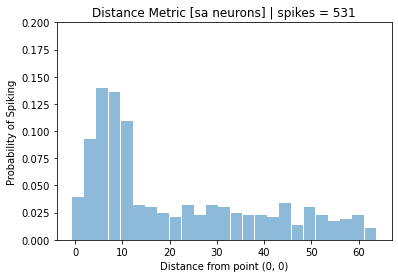

[0.03954802 0.09227872 0.1393597  0.13559322 0.10922787 0.03201507
 0.03013183 0.02448211 0.02071563 0.03201507 0.02259887 0.03201507
 0.03013183 0.02448211 0.02259887 0.02259887 0.02071563 0.03389831
 0.01318267 0.03013183 0.02259887 0.01694915 0.01883239 0.02259887
 0.01129944]


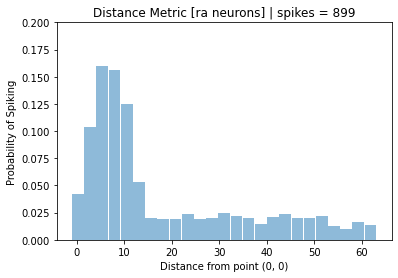

[0.04226919 0.10344828 0.16017798 0.15572859 0.12458287 0.05339266
 0.02002225 0.0189099  0.0189099  0.02335929 0.0189099  0.02002225
 0.02447164 0.02224694 0.02002225 0.01446051 0.02113459 0.02335929
 0.02002225 0.02002225 0.02224694 0.01223582 0.01001112 0.01668521
 0.01334816]


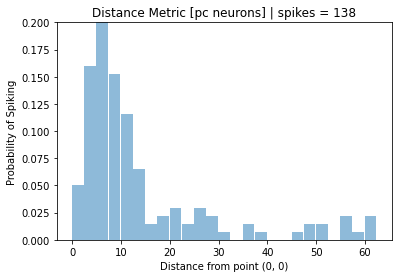

[0.05072464 0.15942029 0.21014493 0.15217391 0.11594203 0.06521739
 0.01449275 0.02173913 0.02898551 0.01449275 0.02898551 0.02173913
 0.00724638 0.         0.01449275 0.00724638 0.         0.
 0.00724638 0.01449275 0.01449275 0.         0.02173913 0.00724638
 0.02173913]


In [7]:
#  Populate a list of identical experiements conducted across different trials
location_set, data_dir = ts.trial_select(data_dir=data_dir, noise=0, obj=2, sensor='ftsn')

bin_min = 0
bin_max = 0.1 #  ideally the longest isi time
bins = 25
bin_step = bin_max / bins
n_bins = np.arange(bin_min, bin_max, bin_step)

reference_point1 = (0, 0)
reference_point2 = (7, 4)

for afferent in ['sa','ra','pc']:
    dist = sta.trial_distance_probabilty_distribution(data_dir, 
                                        trial_filenames=location_set,
                                        reference_point=reference_point1,
                                        n_bins=bins, 
                                        neuron_id=None, 
                                        afferent_type=afferent,
                                        trq_sensor_no=0, 
                                        y_axis_limit=0.2)
    print(dist)